In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using LinearAlgebra
using SparseArrays
using ForwardDiff
using OSQP
using RobotDynamics
using RobotZoo: PlanarRocket
using RobotZoo
using StaticArrays
using Plots
using JLD2
using Test
using Statistics
using ControlSystems
const resfile = joinpath(@__DIR__, "Q3.jld2")
include("rocket.jl")
const isautograder = @isdefined autograder

  Activating environment at `D:\Study_material\Grad_Courses\16745\HW2\homework2-Wenyu-Wu\Project.toml`


false

# Question 3: Writing an MPC Controller (50 pts)
In this problem we'll compare the performance of LQR with a QP-based MPC controller for landing a rocket booster. 

## The Dynamics
We'll be solving a simplified version of the rocket soft landing problem. We'll only be considering a planar version where we control the lateral and vertical movement of the rocket by rotating the thrust vector. The dynamics are as follows:

$$ 
x = \begin{bmatrix} p_x \\ p_z \\ \theta \\ v_x \\ v_z \\ \omega \\ T \\ \phi \end{bmatrix}, \quad
u = \begin{bmatrix} \dot{T} \\ \dot{\phi} \end{bmatrix}, \quad
\dot{x} = \begin{bmatrix}
v_z \\ v_z \\ \omega \\
\frac{T}{m} \cos{(\theta + \phi)} \\ 
\frac{T}{m} \sin{(\theta + \phi)} \\
\frac{T}{2J} L \sin(\phi) \\
\dot{T} \\ \dot{\phi}
\end{bmatrix}
$$
where $p_x$ is the lateral displacement, $p_z$ is the altitude, $\theta$ is the roll angle, $v_x$ and $v_z$ are the linear velocities, $\omega$ is the roll rate, $T$ is the total thrust, $\phi$ is the thrust angle, $\dot{T}$ and $\dot{\phi}$ are the thrust and thrust angle rates, $m$ is the mass, $J$ is the moment of inertia, $L$ is the distance from the thruster to the center of mass, and $g$ is gravity.

To keep our solution stable and safe, we'll saturate our thrust to be between 75%-150% of the nominal gravity-compensating thrust, our thrust angle with $\pm$10 degrees, and our roll angle between $\pm$5 degrees.

Again, we've already defined a `RobotDynamics` model that implements these dynamics for you, but it's helpful to understand the dynamics model you're working with.

**NOTE**: We're using RobotDynamics v0.3.4. A newer version exists with a refreshed API, but we'll stick with this version since it's a little simpler.

## Our Goal
During this problem we will generate an LQR controller, an unconstrained MPC controller, and a constrained MPC controller. We will use each of these controllers to solve a simplified version of the "rocket soft landing problem." The final output using the constrained MPC solver should look something like this:
![rocket](../rocket.gif)

In [2]:
# NOTE: While using global variables is typically discouraged in Julia, feel free to use
#       any of the variables marked "const" within your methods.

# Planar Rocket model
model = PlanarRocket(max_roll=5.0)
const n = state_dim(model)
const m = control_dim(model)
const xeq = [zeros(6); model.m*model.g; 0]
const ueq = zeros(2) 
norm(dynamics(model, xeq, ueq)) ≈ 0 # make sure it's an equilibrium point
const dt = 0.1  # time step (s)
const tf = 25   # time horizon (s)
const N = Int(tf / dt) + 1

# Evaluate the continuous and discrete Jacobians
zeq = KnotPoint(xeq,ueq,dt)   # create a `KnotPoint` type that stores everything together
∇f = RobotDynamics.DynamicsJacobian(model)
jacobian!(∇f, model, zeq)
discrete_jacobian!(RK4, ∇f, model, zeq)

# Extract pieces of the Jacobian
const A = ∇f.A
const B = ∇f.B;

# Cost matrices (using Bryson's Rule)
const Q = Diagonal([
    1.0/5^2; 
    1.0/5^2; 
    1.0/(10*pi/180)^2; 
    10.0/5^2; 
    10.0/5^2; 
    10.0/(10*pi/180)^2;
    1/(.1*model.m*model.g)^2; 
    1/(10*pi/180)^2
])
const R = Diagonal([
    1/(20*model.m*model.g)^2,
    1/(deg2rad(10))^2
])

2×2 Diagonal{Float64, Vector{Float64}}:
 2.59778e-9    ⋅ 
  ⋅          32.8281

## Part (a): Design a reference trajectory (3 pts)
As we saw in previous problem, we'll need a reference trajectory for our controller. However, in this case our reference trajectory is a very simple trajectory that provides a reasonable guess but we expect the actual solution to be different. We'll later see how this reference trajectory affects the performance of our controller.

For the rocket problem, we'll be starting at an altitude of 500m and 200m to the West of our landing location. We'll use a simple linear interpolation from our expected initial state and our goal location. 

In [3]:
# TASK: implement this method (3 pts)
"""
    nominal_trajectory(x0, N, dt)

Generate the nominal trajectory for the rocket problem, given the initial state `x0`,
horizon length `N`, and time step `dt`. 

The guess should be a linear interpolation of the positions.
The velocities should should be consistent with the positions (i.e. constant).
The last state should be have position and velocity of 0, but the same nominal
actuator commands as initial state (i.e. T and ϕ should be constant)

**TIP**: Use a simple finite difference to calculate the velocities.
"""
function nominal_trajectory(x0,N,dt)
    Xref = [fill(NaN, length(x0)) for k = 1:N]
    dx = x0[1]/(N-1)
    dz = x0[2]/(N-1)
    # TODO: Design a trajectory that linearly interpolates from x0 to the origin
    for i = 1:length(Xref)
        Xref[i][1] = x0[1] - (dx*(i-1))
        Xref[i][2] = x0[2] - (dz*(i-1))
        Xref[i][4] = -dx/dt
        Xref[i][5] = -dz/dt
        Xref[i][3] = 0
        Xref[i][6] = 0
        Xref[i][7] = x0[7]
        Xref[i][8] = 0
    end
    Xref[end][4] = 0
    Xref[end][5] = 0
    return SVector{8}.(Xref)
end

nominal_trajectory

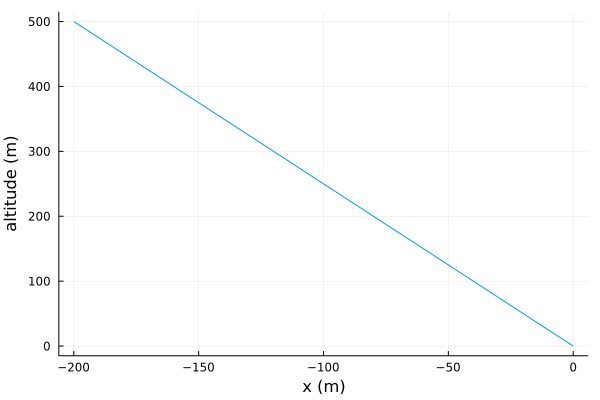

In [4]:
# Start 500m off the ground and 200m West
x0_ref = [-200, 500, 0, 0, 0, 0, 0, 0.] + xeq

# Generate reference trajectory
Xref = nominal_trajectory(x0_ref,N,dt)
Uref = [copy(ueq) for k = 1:N]
tref = range(0,tf, length=N)

# Plot the trajectory
isautograder || traj2(Xref, xlabel="x (m)", ylabel="altitude (m)", label="")

In [40]:
@testset "Q3a" begin                                      # POINTS = 3
    xdiff = diff(Xref)[1:end-1]
    @test mean(xdiff)[1] ≈ 200 / (N-1) rtol = 1e-6        # POINTS = 0.5
    @test mean(xdiff)[2] ≈ -500 / (N-1) rtol = 1e-6       # POINTS = 0.5
    @test mean(xdiff)[3:end] ≈ zeros(6) rtol = 1e-6       # POINTS = 0.5
    
    Xref2 = nominal_trajectory([100,200,0, 0,0,0, 12.2, 0.], 101, 0.15)
    xmean = mean(Xref2[1:end-1])
    @test xmean[4] ≈ -100 / 100 / .15 rtol = 1e-6         # POINTS = 0.5
    @test xmean[5] ≈ -200 / 100 / .15 rtol = 1e-6         # POINTS = 0.5
    @test xmean[6] ≈ 0                                    # POINTS = 0.2
    @test xmean[7] ≈ 12.2                                 # POINTS = 0.2
    @test xmean[8] ≈ 0                                    # POINTS = 0.1
end;

Test Summary: | Pass  Total
Q3a           |    8      8


## Part (b): Design an LQR Controller (5 pts)
As we saw in Q1, a simple infinite-gain LQR controller can work extremely effectively. Write a method to calculate the infinite-horizon gain `K` and cost-to-go `P`. We'll use `K` to control our system and `P` as the $Q_f$ weight matrix for our MPC controller later. It's fine to solve the LQR problem with a long horizon until the cost-to-go converges to a steady-state value. You should NOT use `dlqr` or `dare` from the ControlSystems package, but you can use those methods to check your answer. 

The controller stores a reference trajectory, which is tracked online using the same `K` matrix. This is valid since our dynamics linearization is invariant to the spatial location of the rocket.

In [5]:
# TASK: Implement the following methods:
#       get_control (3 pts)
#       lqr         (2 pts)

"""
    LQRController

Type for evaluting an infinite-horizon time-invariant LQR control policy. 
"""
struct LQRController
    K::Matrix{Float64}
    Xref::Vector{Vector{Float64}}
    Uref::Vector{Vector{Float64}}
    times::Vector{Float64}
end

"""
    get_k(ctrl, t)

Get the time index corresponding to time `t`. 
Useful for implementing zero-order hold control.
Uses binary search to find the time index.
"""
get_k(controller, t) = searchsortedlast(controller.times, t)

"""
    get_control(ctrl, x, t)

Evaluate the LQR feedback policy at state `x` and time `t`, returning the control 
to be executed by the system.
"""
function get_control(ctrl::LQRController, x, t)
    k = get_k(ctrl, t)
    K_vec = ctrl.K
    # TODO: Implement the control policy
    u = ctrl.Uref[k] - K_vec * (x - ctrl.Xref[k])
#     u = fill(NaN, length(ctrl.Uref[1]))
    return u
end

"""
    lqr(A,B,Q,R; kwargs...)

Calculate the infinite-horizon LQR gain from dynamics Jacobians `A` and `B` and
cost matrices `Q` and `R`. Returns the infinite-horizon gain `K` and cost-to-go `P`.

# Keyword Arguments
* `P`: Provide an initial guess for the infinite-horizon gain
* `max_iters`: maximum number of iterations
* `tol`: tolerance for solve
` `verbose`: print the number of iterations
"""
function lqr(A,B,Q,R; P=Matrix(Q), tol=1e-8, max_iters=400, verbose=false)
    # initialize the output
    n,m = size(B)
    K = zeros(m,n)
    
    P_vec = [zeros(n,n) for k = 1:max_iters]
    K_vec = [zeros(m,n) for k = 1:max_iters-1]
    P_vec[end] = Q
    for k = reverse(1:max_iters-1) 
        K_vec[k] .= (R + B'P_vec[k+1]*B)\(B'P_vec[k+1]*A)
        P_vec[k] .= Q + A'P_vec[k+1]*A - A'P_vec[k+1]*B*K_vec[k]
    end
    # TODO: calculate the infinite-horizon LQR solution
#     K .= (R+B'*Q*B)\(B'*Q*A)
#     P .= Q + A'*Q*A - A'*Q*B*K
    # return the feedback gains and ctg matrices
    return K_vec[1],P_vec[1]
end

lqr

In [6]:
# Create LQR controller
K,Qf = lqr(A,B,Q,R)
ctrl = LQRController(K,Xref,Uref,tref);

In [7]:
# Simulate and visualize the result
if !isautograder
    vis = initialize_visualizer(model)
    render(vis)
end

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\ASUS\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("gimbal" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cone" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6d, 0x62, 0x61, 0x6c, 0x2f, 0x63, 0x6f, 0x6e, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6d, 0x62, 0x61, 0x6c, 0x2f, 0x63, 0x6f, 0x6e, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "tip" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x74, 0x69, 0x70], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "fins" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x69, 0x6e, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [8]:
dx = zeros(8)
dx[1:2] .= [10,10]  # we're off from our initial spot by a few meters
dx[5] = -10         # it's coming down a little faster than expected
dx[6] = 1.1         # add some initial angular velocity
x0 = Xref[1] + dx
Xlqr,Ulqr,tlqr = simulate(model, x0, ctrl, tf=50)
isautograder || visualize!(vis, model, tlqr[end] / 10, Xlqr)  # divide the time to speed it up

Controller ran at 25587.51251618726 Hz


In [44]:
@testset "Q3b" begin                          # POINTS = 5
    dx = [
        1.929094900384797,
        1.3289659218797703,
       -1.1940032610827314,
        0.6035052846069947,
        0.1223347579198458,
       -1.0399155799859232,
        0.2632145814885595,
       -1.0004103548732461
    ]
    @test ctrl.K ≈ dlqr(A,B,Matrix(Q),Matrix(R)) rtol = 1e-3   # POINTS = 0.5
    @test Qf ≈ dare(A,B,Matrix(Q),Matrix(R)) rtol = 1e-3       # POINTS = 0.5
    xtest = xeq + dx
    @test all(1:N-1) do k
        get_control(ctrl, Xref[k], tref[k]) ≈ zeros(2)
    end
    @test !(get_control(ctrl, xtest, tref[1]) ≈ get_control(ctrl, xtest, tref[end]))  # POINTS = 0.5
    @test get_control(ctrl, Xref[10] + xtest, tref[10]) ≈ 
        get_control(ctrl, Xref[end] + xtest, tref[end])                               # POINTS = 0.5   

    @test norm(Xlqr[end][4:6]) < 0.1                                                  # POINTS = 1
    @test norm(Xlqr[end][1:3]) < 0.1                                                  # POINTS = 1
    @test minimum([x[2] for x in Xlqr]) < -10
    @test maximum([x[7] for x in Xlqr]) > RobotZoo.umax(model)[1]                     # POINTS = 0.5
    @test maximum([abs(x[3]) for x in Xlqr]) > deg2rad(model.max_roll)                # POINTS = 0.5
end;

Test Summary: | Pass  Total
Q3b           |   10     10


## Part (c): Design an MPC Controller (30 pts)
We'll now design QP-based MPC controller for our rocket. We've set up the basic structure below, which is already setup to work with OSQP. Your job is to generate the QP OSQP will need to solve at each iteration.

Your QP should look something like this:
$$ \begin{align}
    &\text{minimize}_{z} && \frac{1}{2} z^T P z + q^T z \\
    &\text{subject to} && D z = d \\
    &&& C z \leq d \\
\end{align} $$

where $z$ is the concatenated vector of states and controls at each time step. Since we've linearized our system about the point $(x_\text{eq}, u_\text{eq})$, these state and controls are defined relative to this reference. The equality constraints are just the linearized dynamics constraints:

$$ 
\begin{bmatrix} 
    B & -I \\ 
      & A & B & -I \\
      &   &   &   & \ddots \\
      &   &   &   & & A & B -I \\
\end{bmatrix}
\begin{bmatrix} u_0 \\ x_1 \\ u_1 \\ \vdots \\ x_{N-1} \\ u_{N-1} \\ x_N \end{bmatrix} = 
\begin{bmatrix} -A (x_1 - x_{eq}) \\ 0 \\ \vdots \\ 0 \end{bmatrix}
$$

and the cost matrices $P$ and $q$ look are defined as:
$$
P = \begin{bmatrix}
R \\
& Q \\
&& \ddots \\
&&& R \\
&&&& Q_f
\end{bmatrix}, \quad
q = \begin{bmatrix}
    -R(\bar{u}_1 - u_{eq}) \\
    -Q(\bar{x}_2 - x_{eq}) \\
    \vdots \\
    -R(\bar{u}_{N-1} - u_{eq}) \\
    -Q_f(\bar{x}_N - x_{eq}) \\
\end{bmatrix}
$$

Note that the states and controls in our QP are defined relative to our linearization point at the origin $(x_{eq}, u_{eq})$. As the MPC progresses along the horizon, the reference states and controls $(\bar{x},\bar{u})$ will change.

We won't have inequality constraints in this part, but we'll add them in the next section!

In [149]:
# All of the code in this cell is provided. There is no need to modify it.
"""
    MPCController

An MPC controller that uses a solver of type `S` to solve a QP at every iteration.

It will track the reference trajectory specified by `Xref`, `Uref` and `times` 
with an MPC horizon of `Nmpc`. It will track the terminal reference state if 
the horizon extends beyond the reference horizon.
"""
struct MPCController{S}
    P::SparseMatrixCSC{Float64,Int}
    q::Vector{Float64}
    A::SparseMatrixCSC{Float64,Int}
    lb::Vector{Float64}
    ub::Vector{Float64}
    Nmpc::Int
    solver::S
    Xref::Vector{Vector{Float64}}
    Uref::Vector{Vector{Float64}}
    times::Vector{Float64}
end

"""
    OSQPController(n,m,N,Nref,Nd)

Generate an `MPCController` that uses OSQP to solve the QP.
Initializes the controller with matrices consistent with `n` states,
`m` controls, and an MPC horizon of `N`, and `Nd` constraints. 

Use `Nref` to initialize a reference trajectory whose length may differ from the 
horizon length.
"""
function OSQPController(n::Integer, m::Integer, N::Integer, Nref::Integer=N, Nd::Integer=(N-1)*n)
    Np = (N-1)*(n+m)   # number of primals
    P = spzeros(Np,Np)
    q = zeros(Np)
    A = spzeros(Nd,Np)
    lb = zeros(Nd)
    ub = zeros(Nd)
    Xref = [zeros(n) for k = 1:Nref]
    Uref = [zeros(m) for k = 1:Nref]
    tref = zeros(Nref)
    solver = OSQP.Model()
    MPCController{OSQP.Model}(P,q, A,lb,ub, N, solver, Xref, Uref, tref)
end

isconstrained(ctrl::MPCController) = length(ctrl.lb) != (ctrl.Nmpc - 1) * length(ctrl.Xref[1])

"""
    buildQP!(ctrl, A,B,Q,R,Qf; kwargs...)

Build the QP matrices `P` and `A` for the MPC problem. Note that these matrices
should be constant between MPC iterations.

Any keyword arguments will be passed to `initialize_solver!`.
"""
function buildQP!(ctrl::MPCController, A,B,Q,R,Qf; kwargs...)
    if isconstrained(ctrl)
        buildQP_constrained!(ctrl::MPCController, A,B,Q,R,Qf; kwargs...)
    else
        buildQP_unconstrained!(ctrl::MPCController, A,B,Q,R,Qf; kwargs...)
    end
end

"""
    updateQP!(ctrl::MPCController, x, time)

Update the vectors in the QP problem for the current state `x` and time `time`.
This should update `ctrl.q`, `ctrl.lb`, and `ctrl.ub`.
"""
function updateQP!(ctrl::MPCController, x, time)
    if isconstrained(ctrl)
        updateQP_constrained!(ctrl, x, time)
    else
        updateQP_unconstrained!(ctrl, x, time)
    end
end


"""
    initialize_solver!(ctrl::MPCController; kwargs...)

Initialize the internal solver once the QP matrices are initialized in the 
controller.
"""
function initialize_solver!(ctrl::MPCController{OSQP.Model}; tol=1e-6, verbose=false)
    OSQP.setup!(ctrl.solver, P=ctrl.P, q=ctrl.q, A=ctrl.A, l=ctrl.lb, u=ctrl.ub, 
        verbose=verbose, eps_rel=tol, eps_abs=tol, polish=1)
end

"""
    get_control(ctrl::MPCController, x, t)

Get the control from the MPC solver by solving the QP. 
If you want to use your own QP solver, you'll need to change this
method.
"""
function get_control(ctrl::MPCController{OSQP.Model}, x, time)
    # Update the QP
    updateQP!(ctrl, x, time)
    OSQP.update!(ctrl.solver, q=ctrl.q, l=ctrl.lb, u=ctrl.ub)

    # Solve QP
    results = OSQP.solve!(ctrl.solver)
    Δu = results.x[1:2]
    
    k = get_k(ctrl, time)
    return ctrl.Uref[k] + Δu 
end


get_control

In [150]:
# TASK: Implement the following methods:
#       buildQP_unconstrained!  (15 pts)
#       updateQP_unconstrained! (15 pts)
function buildQP_unconstrained!(ctrl::MPCController, A,B,Q,R,Qf; kwargs...)
     # TODO: Implement this method to build the QP matrices
    
    
    # Initialize the included solver
    #    If you want to use your QP solver, you should write your own
    #    method for this function
    
    #----------------build A-----------------#
    r,c = size(ctrl.A)
    row_iter = convert(UInt8,(r/n))
    comp_block = hcat(A,B,-Matrix(I,n,n))
    A_ctrl = ctrl.A
    for i = 1:row_iter
        if (i == 1)
            A_ctrl[1:n,1:m] = B
            A_ctrl[1:n,m+1:m+n] = -Matrix(I,n,n)
        else
            col_start = (i-1)*m + (i-2)*n + 1
            col_end = (m+n)*i
            A_ctrl[(i-1)*n+1:i*n,col_start:col_end] = comp_block
        end
    end
    #----------------build P-----------------#
    r,c = size(ctrl.P)
    rq,cq = size(Q)
    rr,cr = size(R)
    row = rq+rr
    top_right = zeros(rr,cq)
    bot_left = zeros(rq,cr)
    row_iter = convert(UInt8,(r/row))
    comp_block_1 = hcat(R,top_right)
    comp_block_2 = hcat(bot_left,Q)
    comp_block_3 = hcat(bot_left,Qf)
    comp_block = vcat(comp_block_1,comp_block_2)
    comp_block_v2 = vcat(comp_block_1,comp_block_3)
    rc,cc = size(comp_block)
    P_ctrl = ctrl.P
    for i = 1:row_iter
        if (i < row_iter)
            P_ctrl[(i-1)*rc+1:i*rc,(i-1)*cc+1:i*cc] = comp_block
        else
            P_ctrl[(i-1)*rc+1:i*rc,(i-1)*cc+1:i*cc] = comp_block_v2
        end
    end
    initialize_solver!(ctrl; kwargs...)
    return nothing
end


function updateQP_unconstrained!(ctrl::MPCController, x, time)
    # TODO: Implement this method
    N = ctrl.Nmpc-1
    nu = m
    nx = n
    ctrl.q .= 0
    #--------update q attempt 1----------#
    idx_x = [(t-1)*(nu+nx) + nu  .+ (1:nx) for t = 1:N]
    for i = 1:N-1
        idx = get_k(ctrl,time+i*dt)
        ctrl.q[idx_x[i]] = -Q*(ctrl.Xref[idx]-xeq)
#         if (i != N-1)
#             ctrl.q[idx_x[i]] = -Q*(ctrl.Xref[idx]-xeq)
#         else
#             ctrl.q[idx_x[i]] = -Qf*(ctrl.Xref[idx]-xeq)
    end
    i = N
    idx = get_k(ctrl,time+i*dt)
    ctrl.q[idx_x[i]] = -Qf*(ctrl.Xref[idx]-xeq)
    #--------update q attempt 2----------#
#     for i = 1:N
#         idx = get_k(ctrl,time+i*dt)
#         if (mod(i,2) == 1)
#             ctrl.q[i] = -R*(ctrl.Uref[idx]-ueq)
#         elseif (mod(i,2) == 0 & i != N)
#             ctrl.q[i] = -Q*(ctrl.Xref[idx]-xeq)
#         else
#             ctrl.q[i] = -Qf*(ctrl.Xref[idx]-xeq)
#         end
#     end
    #--------update lb ub----------------#
#     idx = get_k(ctrl,1)
    b = -A*(x-xeq)
    ctrl.lb .= 0
    ctrl.ub .= 0
    ctrl.lb[1:nx] = b
    ctrl.ub[1:nx] = b
    return nothing
end

updateQP_unconstrained! (generic function with 1 method)

In [1]:
# Initialize the unconstrained MPC problem
Nmpc = 51           # MPC Horizon
mpc1 = OSQPController(n, m, Nmpc, length(Xref))

# Provide the reference trajectory
mpc1.Xref .= Xref
mpc1.Uref .= Uref
mpc1.times .= tref

# Build the sparse QP matrices
buildQP!(mpc1, A,B,Q,R,Qf, tol=1e-2)

LoadError: UndefVarError: Xref not defined

In [2]:
isautograder || render(vis)

LoadError: UndefVarError: isautograder not defined

In [153]:
Xmpc1,Umpc1,tmpc1 = simulate(model, x0, mpc1, tf=50)
isautograder || visualize!(vis, model, tmpc1[end] / 10, Xmpc1)

Controller ran at 1377.8814729329772 Hz


### Analyzing the Results
Let's look at some plots to see how our LQR and MPC solutions compare.

What do you see? How do the solutions differ? Can you see how the MPC controller is "looking ahead?" 

Your MPC results should be better than your simple LQR controller, but it will still be violating the constraints. Let's add some constraints to our QP to try to fix that!

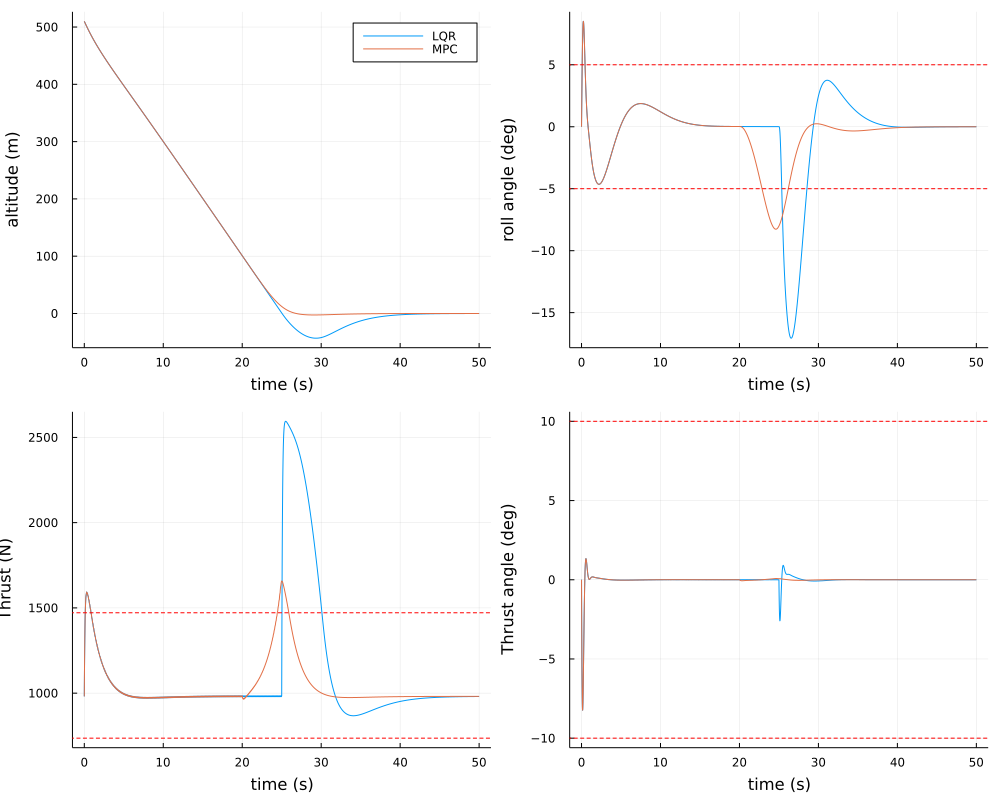

In [154]:
isautograder || comparison_plot(model, (Xlqr,Ulqr,tlqr,"LQR"), (Xmpc1,Umpc1,tmpc1,"MPC"))

In [155]:
using BlockArrays
@testset "Q3c" begin                                   # POINTS = 30
    Np = 50*(n+m)
    Nd1 = 50*n
    @test size(mpc1.P) == (Np,Np)                      # POINTS = 1
    size(mpc1.A) == (Nd1, Np)
    parts1 = fill(n,50)
    parts2 = repeat([m,n],50)
    D = PseudoBlockArray(mpc1.A, parts1, parts2)
    @test D[Block(1,1)] ≈ B                            # POINTS = 1
    @test D[Block(2,1)] ≈ zero(B)                      # POINTS = 1
    @test D[Block(2,2)] ≈ A                            # POINTS = 1
    @test D[Block(2,4)] ≈ -I(n)                        # POINTS = 1
    @test D[Block(3,4)] ≈ A                            # POINTS = 1
    @test D[Block(3,5)] ≈ B                            # POINTS = 1
    @test D[Block(3,6)] ≈ -I(n)                        # POINTS = 1

    H = PseudoBlockArray(mpc1.P, parts2, parts2)
    @test H[Block(1,1)] ≈ R                            # POINTS = 1
    @test H[Block(2,2)] ≈ Q                            # POINTS = 1
    @test H[Block(100,100)] ≈ Qf                       # POINTS = 1
    get_control(mpc1, Xref[1], tref[1])
    g = PseudoBlockArray(mpc1.q, parts2)
    @test g[Block(1)] ≈ zeros(2)                       # POINTS = 1
    @test g[Block(2)] ≈ -Q*(Xref[2] - xeq)             # POINTS = 1
    @test g[Block(3)] ≈ zeros(2)                       # POINTS = 1
    @test g[Block(4)] ≈ -Q*(Xref[3] - xeq)             # POINTS = 1
    @test g[Block(100)] ≈ -Qf*(Xref[51] - xeq)         # POINTS = 1

    get_control(mpc1, Xref[1], tref[10])
    @test g[Block(2)] ≈ -Q*(Xref[11] - xeq)            # POINTS = 1
    @test g[Block(4)] ≈ -Q*(Xref[12] - xeq)            # POINTS = 1

    get_control(mpc1, Xref[1], tref[end-10])
    @test g[Block(2)] ≈ -Q*(Xref[242] - xeq)           # POINTS = 1
    @test g[Block(2*9)] ≈ -Q*(Xref[250] - xeq)         # POINTS = 1
    @test g[Block(2*11)] ≈ zeros(8)                    # POINTS = 1
    @test mpc1.lb[1:n] ≈ -A*(Xref[1] - xeq)            # POINTS = 1

    @test norm(Xmpc1[end][4:6]) < 1e-2                 # POINTS = 1
    @test norm(Xmpc1[end][1:3]) < 1e-2                 # POINTS = 1
    @test minimum([x[2] for x in Xmpc1]) < 0           # POINTS = 2
    @test minimum([x[2] for x in Xmpc1]) > -5          # POINTS = 2
    @test maximum([x[7] for x in Xmpc1]) - RobotZoo.umax(model)[1]  > 10        # POINTS = 1
    @test maximum([abs(x[3]) for x in Xmpc1]) - deg2rad(model.max_roll) > 1e-2  # POINTS = 1
end;

Test Summary: | Pass  Total
Q3c           |   28     28


## Part (d): Add in Constraints (12 pts)
Add the following constraints to your optimization problem:
$$\begin{align}
    |\theta | &\leq 5^{\circ} \\
    |\phi| & \leq 10^{\circ} \\
    z &\geq 0 \\
    0.75 &\leq \frac{1}{mg} T \leq 1.5
\end{align}
$$

**TASK**: Modify the `build_QP` and `update_QP` methods above to add in the  constraints . You should add some logic that checks only adds the constraints if there's room in the matrices, that way we can still use the method to generate our unconstrained solver.

In [171]:
"""
    buildQP!(ctrl, A,B,Q,R,Qf; kwargs...)

Build the QP matrices `P` and `A` for the MPC problem. Note that these matrices
should be constant between MPC iterations.

Any keyword arguments will be passed to `initialize_solver!`.
"""
function buildQP_constrained!(ctrl::MPCController, A,B,Q,R,Qf; kwargs...)
    # TODO: Implement this method to build the QP matrices
    
    # Initialize the included solver
    #    If you want to use your QP solver, you should write your own
    #    method for this function
    r,c = size(ctrl.A)
    get_θ = zeros(Nmpc-1,c)
    get_ϕ = zeros(Nmpc-1,c)
    get_z = zeros(Nmpc-1,c)
    get_T = zeros(Nmpc-1,c)
    for i = 1:(Nmpc-1)
        get_θ[i,(i-1)*(m+n)+5] = 1
        get_ϕ[i,(i-1)*(m+n)+10] = 1
        get_z[i,(i-1)*(m+n)+4] = 1
#         get_T[i,(i-1)*(m+n)+9] = 1/(model.m*model.g)
        get_T[i,(i-1)*(m+n)+9] = 1
    end
    #-----------build new A------------#
#     r,c = size(ctrl.A)
    act_r = (Nmpc-1)*n
    row_iter = convert(UInt8,(act_r/n))
    comp_block = hcat(A,B,-Matrix(I,n,n))
    A_ctrl = ctrl.A
    for i = 1:row_iter
        if (i == 1)
            A_ctrl[1:n,1:m] = B
            A_ctrl[1:n,m+1:m+n] = -Matrix(I,n,n)
        else
            col_start = (i-1)*m + (i-2)*n + 1
            col_end = (m+n)*i
            A_ctrl[(i-1)*n+1:i*n,col_start:col_end] = comp_block
        end
    end
    A_ctrl[act_r+1:act_r+(Nmpc-1),:] = get_θ
    A_ctrl[act_r+(Nmpc-1)+1:act_r+2*(Nmpc-1),:] = get_ϕ
    A_ctrl[act_r+2*(Nmpc-1)+1:act_r+3*(Nmpc-1),:] = get_z
    A_ctrl[act_r+3*(Nmpc-1)+1:act_r+4*(Nmpc-1),:] = get_T
    #------------build same P-----------#
    r,c = size(ctrl.P)
    rq,cq = size(Q)
    rr,cr = size(R)
    row = rq+rr
    top_right = zeros(rr,cq)
    bot_left = zeros(rq,cr)
    row_iter = convert(UInt8,(r/row))
    comp_block_1 = hcat(R,top_right)
    comp_block_2 = hcat(bot_left,Q)
    comp_block_3 = hcat(bot_left,Qf)
    comp_block = vcat(comp_block_1,comp_block_2)
    comp_block_v2 = vcat(comp_block_1,comp_block_3)
    rc,cc = size(comp_block)
    P_ctrl = ctrl.P
    for i = 1:row_iter
        if (i < row_iter)
            P_ctrl[(i-1)*rc+1:i*rc,(i-1)*cc+1:i*cc] = comp_block
        else
            P_ctrl[(i-1)*rc+1:i*rc,(i-1)*cc+1:i*cc] = comp_block_v2
        end
    end
    initialize_solver!(ctrl; kwargs...)
    return nothing
end

"""
    update_QP!(ctrl::MPCController, x, time)

Update the vectors in the QP problem for the current state `x` and time `time`.
This should update `ctrl.q`, `ctrl.lb`, and `ctrl.ub`.
"""
function updateQP_constrained!(ctrl::MPCController, x, time)
    # TODO: Implement this method
    N = ctrl.Nmpc-1
    nu = m
    nx = n
    ctrl.q .= 0
    #--------update q same way----------#
    idx_x = [(t-1)*(nu+nx) + nu  .+ (1:nx) for t = 1:N]
    for i = 1:N-1
        idx = get_k(ctrl,time+i*dt)
        ctrl.q[idx_x[i]] = -Q*(ctrl.Xref[idx]-xeq)
    end
    i = N
    idx = get_k(ctrl,time+i*dt)
    ctrl.q[idx_x[i]] = -Qf*(ctrl.Xref[idx]-xeq)
    #--------update lb---------#
    act_r = (Nmpc-1)*n
    θ_lb = ones(N)*(-deg2rad(5))
    ϕ_lb = ones(N)*(-deg2rad(10))
    z_lb = zeros(N)
    T_lb = ones(N)*0.75*(model.m*model.g) .- xeq[7]
    b = -A*(x-xeq)
    ctrl.lb .= 0
    ctrl.lb[1:nx] = b
    lb_ctrl = ctrl.lb
    lb_ctrl[act_r+1:act_r+(Nmpc-1),:] = θ_lb
    lb_ctrl[act_r+(Nmpc-1)+1:act_r+2*(Nmpc-1),:] = ϕ_lb
    lb_ctrl[act_r+2*(Nmpc-1)+1:act_r+3*(Nmpc-1),:] = z_lb
    lb_ctrl[act_r+3*(Nmpc-1)+1:act_r+4*(Nmpc-1),:] = T_lb
    #---------update ub---------#
    θ_ub = ones(N)*(deg2rad(5))
    ϕ_ub = ones(N)*(deg2rad(10))
    z_ub = ones(N)*Inf
    T_ub = ones(N)*1.5*(model.m*model.g) .- xeq[7]
    ctrl.ub .= 0
    ctrl.ub[1:nx] = b
    ub_ctrl = ctrl.ub
    ub_ctrl[act_r+1:act_r+(Nmpc-1),:] = θ_ub
    ub_ctrl[act_r+(Nmpc-1)+1:act_r+2*(Nmpc-1),:] = ϕ_ub
    ub_ctrl[act_r+2*(Nmpc-1)+1:act_r+3*(Nmpc-1),:] = z_ub
    ub_ctrl[act_r+3*(Nmpc-1)+1:act_r+4*(Nmpc-1),:] = T_ub
#     ub_bk = vcat(ub_ctrl,θ_ub',ϕ_ub',z_ub',T_ub')
#     ub_ctrl = ub_bk
    return nothing
end

updateQP_constrained!

In [172]:
# Initialize the constrained MPC controller
Nd = (Nmpc-1)*(n+4)
mpc2 = OSQPController(n, m, Nmpc, length(Xref), Nd)
mpc2.Xref .= Xref
mpc2.Uref .= Uref
mpc2.times .= tref
buildQP!(mpc2, A,B,Q,R,Qf, tol=1e-2, verbose=false)

In [173]:
isautograder || render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("gimbal" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cone" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6d, 0x62, 0x61, 0x6c, 0x2f, 0x63, 0x6f, 0x6e, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6d, 0x62, 0x61, 0x6c, 0x2f, 0x63, 0x6f, 0x6e, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "fuselage" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x2f, 0x66, 0x75, 0x73, 0x65, 0x6c, 0x61, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "tip" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x74, 0x69, 0x70], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "fins" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x69, 0x6e, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)  …  WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [174]:
Xmpc2,Umpc2,tmpc2 = simulate(model, x0, mpc2, tf=50)
isautograder || visualize!(vis, model, tmpc2[end] / 10, Xmpc2)

Controller ran at 1244.0963572903438 Hz


### Analyzing the results
Let's check our plots again to see how we did! You should see that the solution now (mostly) satisfies the constraints. You should notice that it violates the roll angle limit slightly. Why do you think that is? Is there a way we could prevent that? In the next (and last) section, we'll explore the effects of changing the MPC horizon.

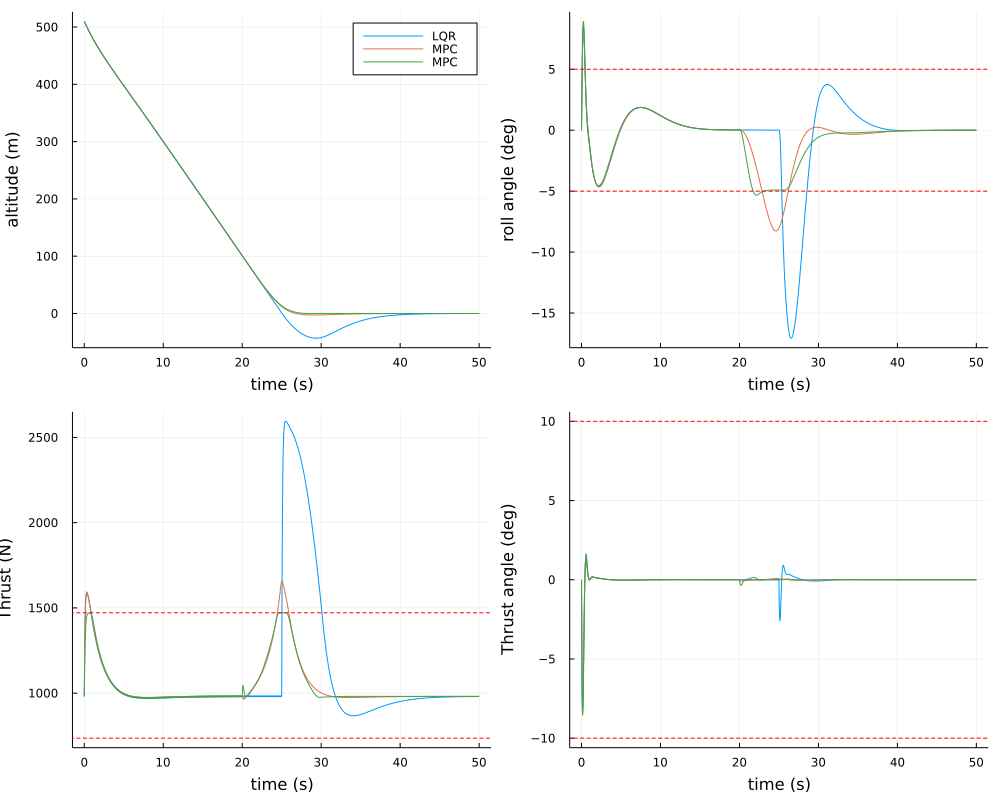

In [175]:
isautograder || comparison_plot(model, (Xlqr,Ulqr,tlqr,"LQR"), (Xmpc1,Umpc1,tmpc1,"MPC"), (Xmpc2,Umpc2,tmpc2,"MPC"))

In [176]:
@testset "Q3d" begin                             # POINTS = 12
    Np = 50*(n+m)
    Nd2 = 50*(n+4)
    @test size(mpc2.A) == (Nd2,Np)               # POINTS = 2

    @test norm(Xmpc2[end][4:6]) < 1e-2           # POINTS = 2 
    @test norm(Xmpc2[end][1:3]) < 1e-2           # POINTS = 2
    @test minimum([x[2] for x in Xmpc2]) < 0     # POINTS = 2
    @test minimum([x[2] for x in Xmpc2]) > -0.1  # POINTS = 2
    @test (maximum([x[7] for x in Xmpc2]) - RobotZoo.umax(model)[1]) < 1e-3     # POINTS = 1
    @test maximum([abs(x[3]) for x in Xmpc2]) - deg2rad(model.max_roll) < 1e-1  # POINTS = 1
end;

Test Summary: | Pass  Total
Q3d           |    7      7


## Part (e): Changing the Horizon
Let's see how our solution changes with the horizon. Note, there's nothing we're asking you to do here, just take minute to look at the plots and convince yourself of what's going on.

In [177]:
# Run with a 1-step horizon
Nmpc = 2

# Constrained MPC
mpc3 = OSQPController(n, m, Nmpc, length(Xref))
mpc3.Xref .= Xref
mpc3.Uref .= Uref
mpc3.times .= tref
buildQP!(mpc3, A,B,Q,R,Qf, tol=1e-2, verbose=false)
Xmpc3,Umpc3,tmpc3 = simulate(model, Xref[1], mpc3, tf=50)

# Constrained MPC
Nd = (Nmpc-1)*(n+4)
mpc4 = OSQPController(n, m, Nmpc, length(Xref), Nd)
mpc4.Xref .= Xref
mpc4.Uref .= Uref
mpc4.times .= tref
buildQP!(mpc4, A,B,Q,R,Qf, tol=1e-2, verbose=false)
Xmpc4,Umpc4,tmpc4 = simulate(model, Xref[1], mpc4, tf=50);

Controller ran at 60836.75167510912 Hz
Controller ran at 42291.111002115824 Hz


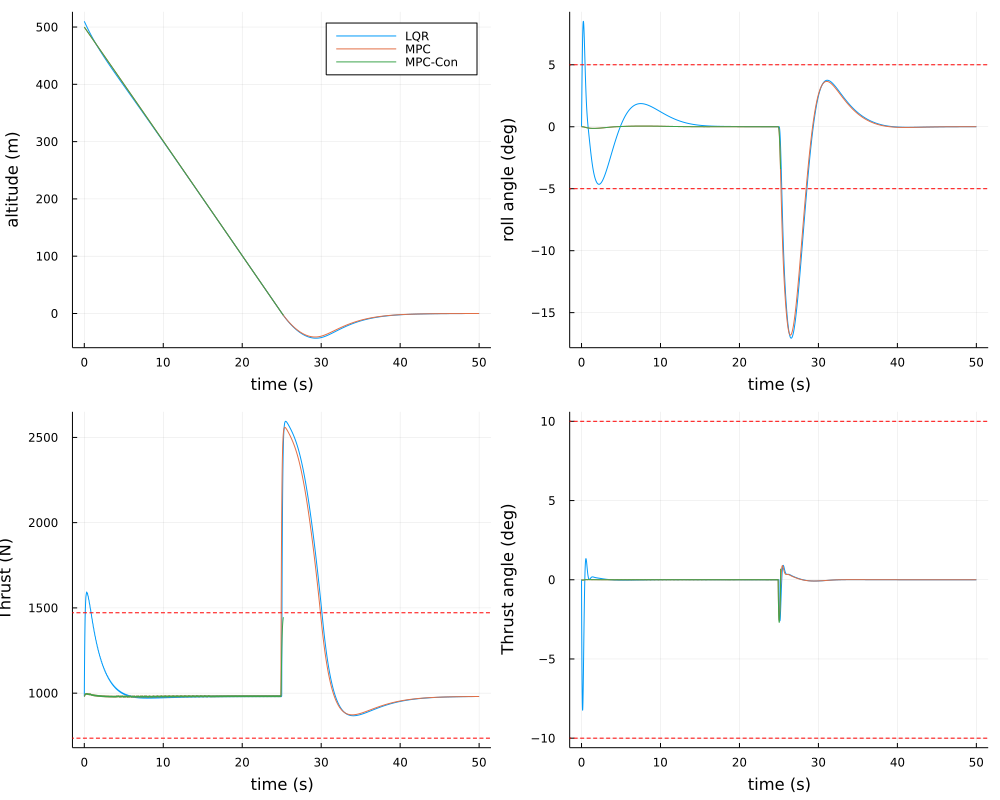

In [178]:
isautograder || comparison_plot(model, (Xlqr,Ulqr,tlqr,"LQR"), (Xmpc3,Umpc3,tmpc3,"MPC"), (Xmpc4,Umpc4,tmpc4,"MPC-Con"))

In [179]:
# Run with a bunch of horizons
horizons = [21,31,41,51,61,71,81,91,101]

Z = map(horizons) do Nmpc
    # Constrained MPC
    println("running with horizon = $Nmpc")
    Nd = (Nmpc-1)*(n+4)
    mpc = OSQPController(n, m, Nmpc, length(Xref), Nd)
    mpc.Xref .= Xref
    mpc.Uref .= Uref
    mpc.times .= tref
    buildQP!(mpc, A,B,Q,R,Qf, tol=1e-2, verbose=false)
    Xmpc,Umpc,tmpc = simulate(model, Xref[1], mpc, tf=50);
    (Xmpc,Umpc,tmpc,"N = " * string(Nmpc))
end;

running with horizon = 21


LoadError: DimensionMismatch("tried to assign 20-element array to 1×1 destination")

In [ ]:
isautograder || comparison_plot(model, Z...)

## Extra Credit: Use your QP Solver
You can earn some extra credit by using the AL QP solver you built in the previous homework. You'll get more extra credit if you modify your QP solver to handle the unique structure that exists in the MPC QP problem. Include an example of using your QP solver below, along with a description of your approach.